<a href="https://colab.research.google.com/github/Collin0034/MW_pulsar_detection/blob/main/Collins_source_training_set_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TO DO: create sample set of maps using PulsarPopPy data, varying size but not luminosity. Change position of observer around the galactic plane to get the most out of each simulation.
# TO DO: set defined color scale, set up for loop, save each image into a zip file with labeled name, save dataframe as a csv

"""
Author: Audrey Do

Create a dataframe of x randomly scattered sources within a 10 kpc sphere. Set radius and luminosity of each source. Calculate the distance of each source from our location (assuming we are
8.5 kpc from the center), which will determine its brightness (~1/r^2). Convert to galactic coordinates and create 2d projection sky-map.
"""

'\nAuthor: Audrey Do\n\nCreate a dataframe of x randomly scattered sources within a 10 kpc sphere. Set radius and luminosity of each source. Calculate the distance of each source from our location (assuming we are\n8.5 kpc from the center), which will determine its brightness (~1/r^2). Convert to galactic coordinates and create 2d projection sky-map.\n'

Install and import packages

In [ ]:
! pip install -q 'healpy==1.13.0' 'astropy==4.0'

     |████████████████████████████████| 11.8 MB 7.9 MB/s 
     |████████████████████████████████| 6.5 MB 14.3 MB/s 


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import healpy as hp
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import axes_grid1
from astropy.coordinates import SkyCoord

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Functions

In [ ]:
def random_coordinates(max_distance):
    """
    returns (x,y,z) coordinate given max distance from center of a sphere in kpc
    this function should uniformly populate a sphere
    """
    #set max distance in kpc
    R = max_distance

    #pick random phi angle in radians (longitude)
    phi = random.uniform(0, 2*np.pi)

    #pick uniformly random theta angle in radians (colatitude)
    costheta = random.uniform(-1,1)
    theta = np.arccos(costheta)

    #pick random distance r
    u = random.random()
    r = R * np.cbrt(u)

    #convert to cartesian
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

In [ ]:
# def equitorial(x, y, z):
#   delta = np.arcsin(z)
#   alpha = np.arccos(x/(np.cos(np.arcsin(z))))

In [ ]:
def xyz_to_galactic_coordinates(x, y, z):
    """
    returns (glatitude, glongitude) coordinate and r (source's distance form Earth in kpc)
    given (x, y, z) position in Milky Way with galactic center as (0, 0, 0) 
    """
    x = x + 8.5   # recenters x on Earth's position (8.5 kpc from center of Milky Way)

    r = np.sqrt(x**2 + y**2 + z**2)   # distance to source from Earth in kpc
  

    ####NOTE: This is lat long transformation for geocentric coordinates (However keep as is since it doesn't really matter what coordinate system we use to make training set images)
    #convert gb from [-90, 90] to [0, 180]
    lat = 90. - np.degrees(np.arcsin(z/r))

    #convert gl from [-180, 180] to [0, 360]
    old_lon = np.degrees(np.arctan2(y,x))
    if old_lon < 0:
      lon = 360 + old_lon
    else:
      lon = old_lon


    
    return lat, lon, r

In [ ]:
def set_source_characteristics(num_points, r, min_radii, max_radii, min_lum, max_lum):
    """
    returns (glatitude, glongitude) coordinate and r (source's distance form Earth in kpc)
    given (x, y, z) position in Milky Way with galactic center as (0, 0, 0) 
    """
    # set source radius
    radius = (max_radii - min_radii) * np.random.rand(num_points) + min_radii

    #calculate angular size
    ang_size = np.degrees(np.arctan2(radius, r))  

    # set source luminosity
    if max_lum > 100:
        lum = np.random.randint(min_lum, max_lum+1, num_points)
    else:
        lum = (max_lum - min_lum) * np.random.rand(num_points) + min_lum

    #calculate apparent brightness (flux)
    flux = lum / (4 * np.pi * (r**2))

    return radius, ang_size, lum, flux

In [ ]:
!mkdir healpy_images #creates folder for images

Manually upload one of Trey's gammapy pulsar population


In [ ]:
!unzip /content/GammaPy_pulsar_populations.zip

skiprows = []
for i in range(1,37):
  skiprows.append(i) #skip explinations of columns found in the ecsv file
df_pulsar = pd.read_csv('/content/1/pulsars.ecsv', delimiter=' ', header=1, skiprows=skiprows) #make pulsar dataframe from gammapy simulation
df_pulsar

Archive:  /content/GammaPy_pulsar_populations.zip
  inflating: 1/plot_psrs.png         
  inflating: 1/pulsars.ecsv          
  inflating: 10/plot_psrs.png        
  inflating: 10/pulsars.ecsv         
  inflating: 2/plot_psrs.png         
  inflating: 2/pulsars.ecsv          
  inflating: 3/plot_psrs.png         
  inflating: 3/pulsars.ecsv          
  inflating: 4/plot_psrs.png         
  inflating: 4/pulsars.ecsv          
  inflating: 5/plot_psrs.png         
  inflating: 5/pulsars.ecsv          
  inflating: 6/plot_psrs.png         
  inflating: 6/pulsars.ecsv          
  inflating: 7/plot_psrs.png         
  inflating: 7/pulsars.ecsv          
  inflating: 8/plot_psrs.png         
  inflating: 8/pulsars.ecsv          
  inflating: 9/plot_psrs.png         
  inflating: 9/pulsars.ecsv          


,age,n_ISM,x_birth,y_birth,z_birth,x,y,z,vx,vy,vz,v_abs,P0,P1,P0_birth,P1_birth,CharAge,Tau0,L_PSR,L0_PSR,B_PSR,E_SN,r_out,r_in,L_SNR,r_out_PWN,distance,GLON,GLAT,VGLON,VGLAT,RA,DEC
0,814183.463780,1.0,0.064147,3.719541,-0.011649,0.277354,3.816408,-0.060082,256.050492,116.331749,-58.164960,287.189994,0.428072,3.251677e-15,0.334241,4.164516e-15,2.205417e-23,1.271632e+06,1.636497e+33,4.402954e+33,1.193884e+12,1.000000e+51,55.578511,50.498635,0.000000e+00,0.549093,12319.676930,1.290030,-0.279425,-1.205123,-0.269996,267.436115,-27.976773
1,26240.648412,1.0,-5.343029,-4.518961,-0.143372,-5.335072,-4.508449,-0.162368,296.512635,391.699033,-707.864827,861.638258,0.685634,4.191888e-15,0.682154,4.213274e-15,4.553738e-23,2.565244e+06,5.134434e+32,5.240015e+32,1.715540e+12,1.000000e+51,14.067205,12.781463,1.076800e+33,0.369687,6664.970968,-53.197194,-1.395947,-4.320376,-6.040652,201.715869,-64.001125
2,153414.895551,1.0,-1.773367,4.214369,-0.015914,-1.748017,4.205293,-0.066098,161.567057,-57.851448,-319.847929,362.978514,0.385943,5.680648e-15,0.357384,6.134595e-15,3.473661e-23,9.230295e+05,3.901101e+33,5.305658e+33,1.498341e+12,1.000000e+51,28.507886,25.902265,0.000000e+00,0.568082,12825.146829,-7.833677,-0.295289,-0.695282,-1.452832,261.699997,-35.695278
3,969869.313986,1.0,-7.620576,8.426991,0.161314,-7.756313,8.046032,0.009140,-136.845577,-384.070710,-153.417711,435.630596,0.281171,4.440364e-15,0.051303,2.433592e-14,1.978131e-23,3.340100e+04,7.886183e+33,7.115145e+36,1.130692e+12,1.000000e+51,59.607826,54.159671,0.000000e+00,1.791020,18273.796738,-25.115858,0.028657,0.920062,-0.492651,246.658194,-49.018169
4,937295.060149,1.0,-16.708736,-2.660650,0.068731,-16.929680,-2.487176,0.425210,-230.489761,180.969185,371.881051,473.466886,0.414525,4.832522e-16,0.399975,5.008308e-16,3.173877e-24,1.265342e+07,2.678446e+32,3.089951e+32,4.529101e+11,1.000000e+51,58.798809,53.424598,0.000000e+00,0.334522,17970.779705,-70.446759,1.355812,-0.304607,1.176388,166.388284,-58.738098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,540945.195514,1.0,2.615560,3.659396,-0.016693,2.575650,3.874020,-0.288756,-72.140073,387.946838,-491.771318,630.512465,0.528157,9.065961e-15,0.339808,1.409102e-14,7.586520e-23,3.820829e+05,2.429324e+33,1.417751e+34,2.214309e+12,1.000000e+51,47.193187,42.879730,0.000000e+00,0.678062,12642.536247,11.758211,-1.308752,0.693949,-2.213149,274.058866,-19.377559
996,912115.697712,1.0,-1.131933,0.199677,0.041843,-0.882255,0.318302,0.160492,267.656050,127.166668,127.192062,322.473166,0.431241,1.922708e-15,0.371801,2.230092e-15,1.313710e-23,2.641520e+06,9.464826e+32,1.712973e+33,9.214392e+11,1.000000e+51,58.161818,52.845827,0.000000e+00,0.461463,8863.779001,-5.713327,1.037482,-1.844637,0.802379,261.791146,-33.192054
997,80258.530667,1.0,3.916134,-9.651652,-0.019055,3.923435,-9.620677,-0.003692,88.943527,377.366444,187.162195,430.518375,0.742437,1.111912e-13,0.364747,2.263280e-13,1.307964e-21,2.553403e+04,1.072635e+34,1.841294e+35,9.194219e+12,1.000000e+51,21.999585,19.988823,0.000000e+00,1.051836,4080.352136,105.941290,-0.051845,5.561691,2.693393,339.082549,58.291091
998,934790.424809,1.0,3.976047,-6.606388,0.060925,3.977127,-6.632138,0.124465,1.130199,-26.935338,66.462750,71.722290,0.434395,1.937088e-16,0.428643,1.963084e-16,1.333215e-24,3.459573e+07,9.329418e+31,9.840399e+31,2.935398e+11,1.000000e+51,58.735910,53.367448,0.000000e+00,0.268882,4395.672784,64.842857,1.622569,-0.331544,0.859262,297.124504,28.892691


In [ ]:
# print(np.max(df_pulsar['r_out_PWN']))
# print(np.min(df_pulsar['r_out_PWN']))
# print()
# print(np.max(df_pulsar['distance']))
# print(np.min(df_pulsar['distance']))
# print()
# print(np.max(df_pulsar['L_PSR']))
# print(np.min(df_pulsar['L_PSR']))
# print()
# print(np.max(df_pulsar['L_PSR'])**math.log(10, np.max(df_pulsar['L_PSR'])))
# print(math.log(100, np.max(df_pulsar['L_PSR'])))
# print(np.min(df_pulsar['L_PSR'])**math.log(10, np.max(df_pulsar['L_PSR'])))
# # print(np.max(df_pulsar['L_PSR'])**np.log(np.max(df_pulsar['L_PSR'])))
# np.mean(df_pulsar['L_PSR'])

Set Parameters

Approximate resolution at NSIDE 512 is 0.11 deg
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
Approximate resolution at NSIDE 512 is 0.11 deg
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
Approximate resolution at NSIDE 512 is 0.11 deg
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/lo

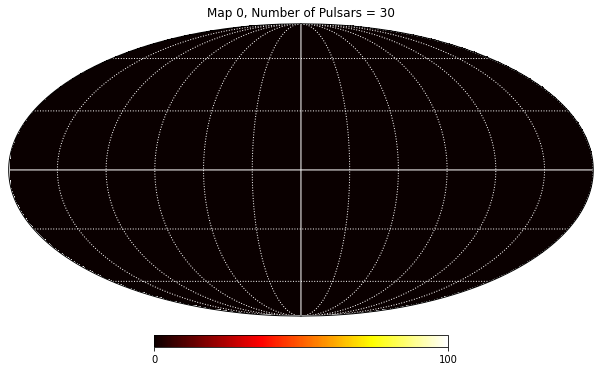

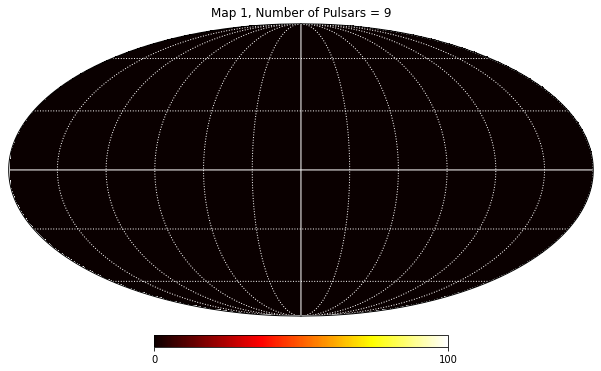

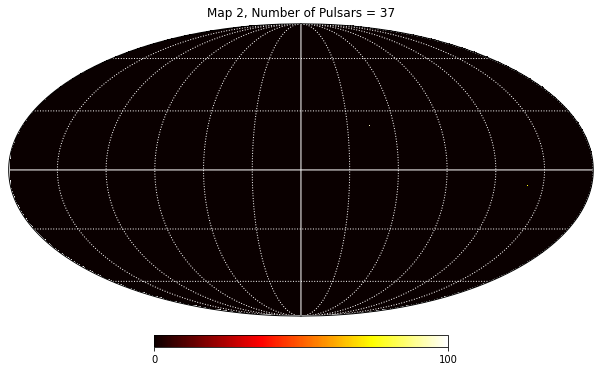

In [ ]:
num_imgs = 3 #number of simulations to run
master_pulsar_df = pd.DataFrame()
# classes = []
gb = []
gl = []
ang_r = []
luminosities = []

for n in range(num_imgs):
    # number of sources to generate per map
    max_num_points = 50
    num_points = np.random.randint(1, max_num_points+1)

    # source radii range
    # min_radii = np.min(df_pulsar['r_out_PWN'])/1000 #convert to kpc
    # max_radii = np.max(df_pulsar['r_out_PWN'])/1000
    min_radii = .03
    max_radii = .03
    # min_lum = np.min(df_pulsar['L_PSR'])**math.log(100, np.max(df_pulsar['L_PSR']))   
    # max_lum = np.max(df_pulsar['L_PSR'])**math.log(100, np.max(df_pulsar['L_PSR'])) #exponent is there to make max 100 based on gammapy luminosity data, Dont want to use numbers higher than 10^19 since healpy stops plotting them at that point
    # min_lum = 1
    # max_lum = np.max(df_pulsar['L_PSR'])/np.min(df_pulsar['L_PSR'])
    min_lum = 1
    max_lum = 100
    # source luminosity range   

    #initialize dataframe
    pulsar_df = pd.DataFrame()

    simulation_run = []
    source_number = []
    x_pos = []
    y_pos = []
    z_pos = []
    galactic_latitude = []
    galactic_longitude = []
    distance_from_earth = []
    source_radius = []
    angular_size = []
    source_lum = []
    source_flux = []
    # color = []
    #fill up dataframe with num_points random sources (just do single source for now)
    for i in range(num_points):
        simulation_run.append(n+1) #keeps track of which simulation run this is
        source_number.append(i+1) #keeps count of each source within that simulation
       
        x, y, z = random_coordinates(np.max(df_pulsar['distance']/1000)) #converts to kpc xyz
        x_pos.append(x)
        y_pos.append(y)
        z_pos.append(z)

        lat, lon, r = xyz_to_galactic_coordinates(x, y, z)
        galactic_latitude.append(lat)
        galactic_longitude.append(lon)
        distance_from_earth.append(r)


    radius, ang_size, lum, flux = set_source_characteristics(num_points, r, min_radii, max_radii, min_lum, max_lum)
    source_radius = radius
    angular_size = ang_size
    source_lum = lum
    source_flux = flux

    adjusted_gl = np.where(np.array(galactic_longitude) <= 180, 180-np.array(galactic_longitude), 540-np.array(galactic_longitude))
    # color.append(np.around(lum))
    # classes.append(color)
    gb.append(np.array(galactic_latitude))
    gl.append(adjusted_gl)
    ang_r.append(angular_size)
    luminosities.append(np.array(source_lum))


    pulsar_df['map number'] = simulation_run
    pulsar_df['source number'] = source_number
    pulsar_df['x (kpc)'] = x_pos
    pulsar_df['y (kpc)'] = y_pos
    pulsar_df['z (kpc)'] = z_pos
    pulsar_df['gb (degrees)'] = galactic_latitude
    pulsar_df['gl (degrees)'] = adjusted_gl
    pulsar_df['R (kpc)'] = distance_from_earth   
    pulsar_df['radius (kpc)'] = source_radius                    
    pulsar_df['angular size (degrees)'] = angular_size        
    pulsar_df['luminosity (arbitrary units)'] = source_lum       
    pulsar_df['brightness (arbitrary units)'] = source_flux  


    #Plot the Mollweide projection
    NSIDE = 512
    print(
        "Approximate resolution at NSIDE {} is {:.2} deg".format(
            NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60  #Give approximate resolution (pixel size in radian or arcmin) for nside. Resolution is just the square root of the pixel area, which is a gross approximation given the different pixel shapes
        )
    )

    NPIX = hp.nside2npix(NSIDE) #Give the number of pixels for the given nside.

    additive=True
    # print(NPIX)

    m = np.arange(NPIX)
    m*=0 #create array full of zeros for length NPIX
    theta = np.radians(galactic_latitude)
    phi = np.radians(galactic_longitude)

    #create array that fills in location of pulsars and their luminosities
    for i in range(num_points): 
        vec = hp.ang2vec(theta[i], phi[i]) #convert angles to a 1D array of shape (3,)
        # print(vec)
        ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(ang_size[i])) #returns pixels whose centers lie within the disk defined by vec and radius (in radians) 
        # print(ipix_disc)
        # print(len(ipix_disc))

        if additive: 
            m[ipix_disc] = m[ipix_disc] + lum[i] #add luminosities of overlapping pulsars
        else:
            m[ipix_disc] = lum[i]
    # print(max(m))
    #"map #" + str(n+1) + ": " + str(num_points) +  " source(num_imgs) - varied size and luminosity",
    # fig, (ax1, ax2) = plt.subplots(ncols=2)
    # ax1 = fig.add_subplot(111, projection="mollweide")

    # pos2ax = (ax1.transData+ax1.transAxes.inverted()).transform
    # x, y = zip(*[pos2ax((ra,de)) for ra, de in zip(galactic_longitude, galactic_latitude)]) 
    # print(x,y)
    # plt.axes(ax1)
    # ax1.plot(x, y, transform=ax1.transAxes, color='Blue', alpha=1.5)
    # plt.axes(ax2)
    # graph = hp.mollview(m, title= f'Map {n}', cmap = 'hot', min=40, max=max_lum, norm='log', return_projected_map=True)#, hold=True)
    graph = hp.mollview(m, title= f'Map {n}, Number of Pulsars = {num_points}', cmap = 'hot', xsize=720, min=0, max=max_lum, margins='bottom', return_projected_map=True) #Colors = {[int(j) for j in luminosities[n]]}', cmap = 'hot', xsize=720, min=0, max=max_lum, margins='bottom', return_projected_map=True)#, hold=True)
    hp.graticule(color='white')

    # plt.gca().add_patch(matplotlib.patches.Rectangle((50, 50), 500, 500, ec='r', fc='none'))
    plt.savefig("healpy_images/map{n}.png".format(n=n), dpi=720/8.08) #made dpi 720/8.08 instead of 89.1 cause I was just being weird and don't feel like changing it
    master_pulsar_df = pd.concat([master_pulsar_df, pulsar_df], ignore_index=True)

gb = np.array(gb)
gl = np.array(gl)
ang_r = np.array(ang_r)
luminosities = np.array(luminosities)

# print(classes[:5])
# print(graph.shape)
# # pp=0
# for i in range(len(graph)):
#   for j in range(len(graph[0])):
#     # zip(*np.where(graph => 1))
#     if graph[i][j]>0:
#       pp +=1
# print(pp)
# print(zip(*np.where(graph >= 0)))
# info = np.asarray(np.where(graph > 0)).T
# len(info)

In [ ]:
# print(gb[:5])
# print(gl[:5])
# print(ang_r[:5])
# print(luminosities[:5])

In [ ]:
#proof of this can be found at https://en.wikipedia.org/wiki/Mollweide_projection
def theta_iteration(lat): #numerically solve for theta approximation
    lat = np.radians(lat)
    thetaa = lat - (2*lat + np.sin(2*lat) - np.pi*np.sin(lat))/(2 + 2*np.cos(2*lat))
    for i in range(1000):
        thetaa = thetaa - (2*thetaa + np.sin(2*thetaa) - np.pi*np.sin(lat))/(2 + 2*np.cos(2*thetaa))
    return(thetaa)

image = cv2.imread('healpy_images/map0.png') #using this image strictly for the size of the images. Nothing special about map0
image_shape = image.shape
boxes = []
for img in range(num_imgs): 
    Theta = theta_iteration(90 - gb[img])
    # print(Theta)
    lamb = np.radians(180 - gl[img]) #longitude
    R_guess = np.radians(180)/(2*np.sqrt(2))

    x_guess = R_guess*(2*np.sqrt(2)/np.pi)*(lamb)*np.cos(Theta)
    x_guess = 180 - np.degrees(x_guess)

    y_guess = R_guess*np.sqrt(2)*np.sin(Theta)
    y_guess = np.degrees(y_guess)*(-1)+90

    # print(x_guess)
    # print(y_guess)
    img_boxes = []
    for k in range(len(x_guess)): #pack coordinates of bottom left corner of bounding rectangle and the height, width, and color of the box and ellipse in the array as well
        x1 = 0.025*image_shape[1] + 2*(x_guess[k] - ang_r[img][k]) - 3 #using -3 just to make the box go a little bit outside the ellipse
        y1 = 0.06*image_shape[0] + 2*(y_guess[k] - ang_r[img][k]) - 3
        r = 4*ang_r[img][k] + 4 #using +4 just to make the box go a little bit outside the ellipse
        color = luminosities[img][k]
        img_boxes.append([x1, y1, r, color])
    boxes.append(img_boxes)
# print(boxes)
# print(boxes[4])
# print(boxes[0][0][3])

18
28
719
362
(481, 757, 3)
[ 7.93870852 34.10141301 14.87401242 69.86950629 15.86119913 94.37157475
 50.06339949 94.14488928 39.56022595 33.48666127 44.41420672 40.66837688
 11.76658641 92.35004747 58.44691189  6.16222379 31.59983323 52.9033417
 81.36316012 78.20303976 98.35450287 76.07553386 67.01745431 91.38153685
 58.52349443 53.13409285 39.59556494 59.95750348 77.80539849 68.46512557
  1.50862233 70.83726301 35.33702925 81.62014048 30.65643197  1.94628308
 56.98339507]


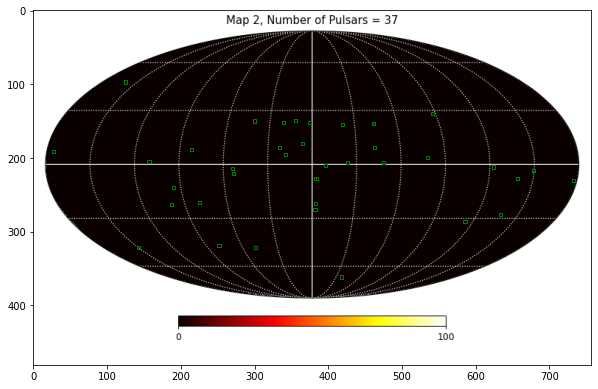

In [ ]:
#check to see if the ellipses are properly bounded by the rectangles
i = np.random.randint(num_imgs)
image = cv2.imread(f'healpy_images/map{i}.png') #convert healpy image into a bgr array
b,g,r = cv2.split(image) #seperate color components 
image = cv2.merge([r,g,b]) #reorganize from bgr to rgb array
fig = plt.figure(figsize=(10, 10))
plt.imshow(image)
for box in boxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((box[0], box[1]), box[2], box[2], ec='g', fc='none')) #gives rectangular box around ellipses
    # plt.title(f'Colors = {[int(j) for j in luminosities[i]]}') #number of objects in an image
    # image = cv2.rectangle(image, (x1, y1), (x2, y2), color = (0, 255, 0), thickness=1 )

##use these lines to make rectangle around individual ellipse using cv2 instead of matplotlib
# k = 0
# x1 = int(0.025*len(image[0]) + 2*(x_guess[i][k] - boxes[i][k][2])) - 3
# y1 = int(0.06*len(image) + 2*(y_guess[i][k] - boxes[i][k][2])) - 3
# x2 = int(0.025*len(image[0]) + 2*(x_guess[k] + boxes[i][k][2])) + 3
# y2 = int(0.06*len(image) + 2*(y_guess[i][k] + boxes[i][k][2])) + 3
# image = cv2.rectangle(image, (x1, y1), (x2, y2), color = (0, 255, 0), thickness=1 ) 

#use these lines to find out the center of the ellipses
# gglon = int(0.025*len(image[0]) + 2*x_guess[k]-5)
# gglat = int(0.06*len(image) + 2*y_guess[k]-5)
# image = cv2.line(image, (gglon,0), (gglon, len(image)), color = (0, 255, 0), thickness=1)
# image = cv2.line(image, (0, gglat), (len(image[0]), gglat), color = (0, 255, 0), thickness=1)

##use these lines to find out the rough estimate spacing between the image edge and the mollweide map
# image = cv2.line(image, (int(0.025*len(image[0])),0), (int(0.025*len(image[0])), len(image)), color = (0, 255, 0), thickness=1)
# image = cv2.line(image, (0, int(0.06*len(image))), (len(image[0]), int(0.06*len(image))), color = (0, 255, 0), thickness=1)
# image = cv2.line(image, (0, int(0.814*len(image))), (len(image[0]), int(0.814*len(image))), color = (0, 255, 0), thickness=1)

plt.imshow(image)#, extent= [0, len(image[0]), 0, len(image)]) #plot image

print(int(0.025*len(image[0])))
print(int(0.06*len(image)))
# print(len(image[0]))
# print(len(image))
print(int(len(image[0])-2*0.025*len(image[0])))
print(int(0.814*len(image) - 0.06*len(image)))
# print(gglat)
# print(int(0.06*len(image[0])+2*master_pulsar_df['gb (degrees)'][0]))
# print(master_pulsar_df['gb (degrees)'][3])
# print(min(master_pulsar_df['gl (degrees)']))
print(image.shape)
print(luminosities[i])

In [ ]:
 master_pulsar_df

,map number,source number,x (kpc),y (kpc),z (kpc),gb (degrees),gl (degrees),R (kpc),radius (kpc),angular size (degrees),luminosity (arbitrary units),brightness (arbitrary units)
0,1,1,-11.989164,-6.663657,-6.522287,130.928865,297.637047,9.955843,0.813866,3.773305,9.148134,0.004780
1,1,2,-17.877855,-7.920622,-1.265722,95.887085,319.815261,12.340278,2.445981,11.211350,68.941131,0.036026
2,2,1,10.352889,5.924175,-18.184058,132.619138,162.555629,26.854929,1.797296,10.134444,69.112715,0.054399
3,2,2,-12.557058,-6.362064,-6.645777,131.372071,302.525464,10.054945,1.839349,10.366486,49.332550,0.038830
4,3,1,1.131082,-11.702693,-11.066965,126.136670,230.546303,18.766685,2.273593,5.818949,45.633265,0.007296
...,...,...,...,...,...,...,...,...,...,...,...,...
100,49,2,2.689464,17.607700,-1.087189,92.983135,122.435426,20.890600,2.292577,8.744305,87.144773,0.031215
101,49,3,-11.567129,-10.286297,10.341316,46.066992,286.603330,14.904965,2.017865,7.709947,50.327365,0.018027
102,50,1,7.533899,4.667617,-9.722456,120.208016,163.769230,19.323528,0.160622,0.530633,27.248152,0.007209
103,50,2,-2.102177,14.680121,-0.314224,91.124125,113.548316,16.016767,0.694042,2.291686,62.952932,0.016656


In [ ]:
# master_pulsar_df.to_csv('master_pulsar_data.csv')

In [ ]:
def color_class(color, num_classes):
    bin_length = max_lum/num_classes
    bin_range = 0
    for i in range(num_classes):
        if bin_range < color <= bin_range+bin_length: #with max_lum =100 and num_classes=10 bins will be 1-10, 11-20, 21-30, etc...
            colors = i
        bin_range = bin_range + bin_length
    return(colors)


def convert(image_size, box, color):
    dw = 1. / image_size[0]
    dh = 1. / image_size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    num_classes = 10
    classes = color_class(color, num_classes)

    return [classes, x, y, w, h] #zero is there to identify the class number, and we are only detecting ellipses so this will always be zero

def convert_to_yolo_label(bbox, img_w = image_shape[1], img_h = image_shape[0]):
    xmin = bbox[0]
    xmax = bbox[0] + bbox[2]
    ymin = bbox[1]
    ymax = bbox[1] + bbox[2]
    box = (float(xmin), float(xmax), float(ymin), float(ymax))
    yolo_box = convert((img_w, img_h), box, bbox[3])
    if np.max(yolo_box[1:]) > 1 or np.min(yolo_box[1:]) < 0: # Take this opportunity to check that conversion works
        print("BOX HAS AN ISSUE")
    return yolo_box

In [ ]:
# bboxes = []
# for img in range(3): #save the images
#   labels = []
#   ii = 0
#   for box in boxes[img]:
#     ii +=1
#     yolo_box = convert_to_yolo_label(box) #create label for yolo to recognize position of ellipse
#     # print(f'image = {img}, box_num = {ii}',yolo_box)
#     labels.append(yolo_box)
#   print(labels)

In [ ]:
#create folders for training and test images
# !mkdir ellipse_images #creates folder called ellipse_images
!mkdir obj
!mkdir test

In [ ]:
images = [cv2.imread(f'healpy_images/map{i}.png') for i in range(num_imgs)]
images = np.array(images)

bboxes = []
for img in range(num_imgs): #save the images
  labels = []
  for box in boxes[img]:
    yolo_box = convert_to_yolo_label(box) #create label for yolo to recognize position of ellipse
    labels.append(yolo_box)
  if img <= 0.75*num_imgs: 
    text = np.savetxt("/content/obj/ellipse_img"+str(img)+".txt", (labels),  fmt='%d %s %s %s %s')
    image = cv2.imwrite('/content/obj/ellipse_img'+str(img)+'.jpg', images[img]) 
    
  else:
    text = np.savetxt("/content/test/ellipse_img"+str(img)+".txt", (labels),  fmt='%d %s %s %s %s')
    image = cv2.imwrite('/content/test/ellipse_img'+str(img)+'.jpg', images[img]) 
  bboxes.append(labels)

  

a = open("/content/obj/ellipse_img"+str(1)+".txt", 'r')# open file in read mode to check
print("the file contains:")
print(a.read())
# # print(boxes[1])
# # print(bboxes[1])

the file contains:
6 0.46115650443770845 0.6428985206518693 0.05883457738965326 0.09259412699369547
4 0.7700385187194054 0.637180643750611 0.06006069030624571 0.09452378910982964



**Make sure to delete any previous obj.zip or test.zip files** from yolov4 folder in google drive before executing next box of code

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive


In [ ]:
%cd ..
!cp -r /content/obj ./
!cp -r /content/test ./
!ls

/
bin	 dev   lib32  mydrive  python-apt  srv		      tmp
boot	 etc   lib64  obj      root	   sys		      tools
content  home  media  opt      run	   tensorflow-1.15.2  usr
datalab  lib   mnt    proc     sbin	   test		      var


In [ ]:
#make obj and test folders into zip files and save them to yolov4 folder in google drive
%cd content
!zip -r /mydrive/yolov4/obj.zip /obj
!zip -r /mydrive/yolov4/test.zip /test

/content
  adding: obj/ (stored 0%)
  adding: obj/ellipse_img26.jpg (deflated 6%)
  adding: obj/ellipse_img37.jpg (deflated 7%)
  adding: obj/ellipse_img33.txt (deflated 45%)
  adding: obj/ellipse_img9.txt (deflated 41%)
  adding: obj/ellipse_img0.jpg (deflated 7%)
  adding: obj/ellipse_img34.jpg (deflated 7%)
  adding: obj/ellipse_img25.txt (deflated 41%)
  adding: obj/ellipse_img35.jpg (deflated 7%)
  adding: obj/ellipse_img27.txt (deflated 27%)
  adding: obj/ellipse_img23.jpg (deflated 7%)
  adding: obj/ellipse_img12.txt (deflated 46%)
  adding: obj/ellipse_img7.jpg (deflated 7%)
  adding: obj/ellipse_img23.txt (deflated 29%)
  adding: obj/ellipse_img3.txt (deflated 41%)
  adding: obj/ellipse_img6.jpg (deflated 7%)
  adding: obj/ellipse_img36.jpg (deflated 7%)
  adding: obj/ellipse_img2.txt (deflated 46%)
  adding: obj/ellipse_img20.txt (deflated 42%)
  adding: obj/ellipse_img29.txt (deflated 41%)
  adding: obj/ellipse_img19.txt (deflated 41%)
  adding: obj/ellipse_img10.jpg (deflat

In [ ]:
# !mkdir images #creates folder called ellipse_images
# # !mkdir ellipse_images/obj #creates folder for training images
# # !mkdir ellipse_images/test #creates folder for test images
# # !mkdir obj #creates folder for training images
# # !mkdir test #creates folder for training images
# bboxes = []
# for img in range(num_imgs): #save the images
#   labels = []
#   for box in boxes[img]:
#     yolo_box = convert_to_yolo_label(box) #create label for yolo to recognize position of ellipse
#     labels.append(yolo_box)
#     text = np.savetxt("/content/images/ellipse_img"+str(img)+".txt", (labels),  fmt="%.16f")
#     image = cv2.imwrite('/content/images/ellipse_img'+str(img)+'.jpg', images[img])  #multiply by 256 so that the image doesn't come out as all black
    
#   #   # text = np.savetxt("/content/obj/ellipse_img"+str(img)+".txt", (labels),  fmt="%.10f")
#   #   # image = cv2.imwrite('/content/obj/ellipse_img'+str(img)+'.jpg', imgs[img]*256)  #multiply by 256 so that the image doesn't come out as all black
    
#   #   # text = np.savetxt("/content/ellipse_images/obj/ellipse_img"+str(img)+".txt", (labels),  fmt="%.10f")
#   #   # image = cv2.imwrite('/content/ellipse_images/obj/ellipse_img'+str(img)+'.jpg', imgs[img]*256)  #multiply by 256 so that the image doesn't come out as all black

#   # else:
#   #   text = np.savetxt("/content/ellipse_images/test/ellipse_img"+str(img)+".txt", (labels),  fmt="%.10f")
#   #   image = cv2.imwrite('/content/ellipse_images/test/ellipse_img'+str(img)+'.jpg', imgs[img]*256)  #multiply by 256 so that the image doesn't come out as all black
#   bboxes.append(labels)

  

# a = open("/content/images/ellipse_img"+str(1)+".txt", 'r')# open file in read mode to check
# print("the file contains:")
# print(a.read())
# # print(boxes[1])
# # print(bboxes[1])

the file contains:
6.0000000000000000 0.4686677248005170 0.4340658580076026 0.0288274839453837 0.0453688260845227
5.0000000000000000 0.5158472036084594 0.2078146455102561 0.0270738682283001 0.0426089776482810
3.0000000000000000 0.4721032704076477 0.5580897246069558 0.0318914911022946 0.0501909745622391



In [ ]:
# def convertYoloToCOCO(size, coord):
#     x2 = int(((2*size[0]*float(coord[0]))+(size[0]*float(coord[2])))/2)
#     x1 = int(((2*size[0]*float(coord[0]))-(size[0]*float(coord[2])))/2)

#     y2 = int(((2*size[1]*float(coord[1]))+(size[1]*float(coord[3])))/2)
#     y1 = int(((2*size[1]*float(coord[1]))-(size[1]*float(coord[3])))/2)

#     x2 = x2-x1
#     y2 = y2-y1
#     return (x1,y1,x2,y2)

# for j in range(5):
#   for i in range(len(bboxes[j])):
#     a = convertYoloToCOCO((img_size, img_size), bboxes[j][i])
#     print(a)
# print(boxes)

In [ ]:
# !rm -rf /obj #deletes folder
# !rm -rf /test

In [ ]:
# !zip -r /content/images.zip /content/images #create a zip folder to eventually save to desktop
# !zip -r /content/obj.zip /content/ellipse_images/obj #create a zip folder to eventually save to desktop
# !zip -r /content/test.zip /content/ellipse_images/test #create a zip folder to eventually save to desktop

  adding: content/images/ (stored 0%)
  adding: content/images/ellipse_img2.jpg (deflated 14%)
  adding: content/images/ellipse_img3.jpg (deflated 11%)
  adding: content/images/ellipse_img4.txt (deflated 55%)
  adding: content/images/ellipse_img1.txt (deflated 54%)
  adding: content/images/ellipse_img4.jpg (deflated 21%)
  adding: content/images/ellipse_img3.txt (deflated 66%)
  adding: content/images/ellipse_img0.jpg (deflated 12%)
  adding: content/images/ellipse_img0.txt (deflated 67%)
  adding: content/images/ellipse_img2.txt (deflated 67%)
  adding: content/images/ellipse_img1.jpg (deflated 22%)


In [ ]:
# from google.colab import files
# files.download("/content/images.zip") #save images to desktop
# files.download("/content/obj.zip") #save images to desktop
# files.download("/content/test.zip") #save images to desktop

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>